# Video Games Category - Business Questions Implementation

**Category**: Video Games

**Team Member**: Yaiechnyk Oleh

## 0) Setup

In [1]:
import os
from amazon_reviews_analysis.utils import build_spark

spark = build_spark()
print("Spark version:", spark.version)


openjdk version "17.0.15" 2025-04-15
OpenJDK Runtime Environment Temurin-17.0.15+6 (build 17.0.15+6)
OpenJDK 64-Bit Server VM Temurin-17.0.15+6 (build 17.0.15+6, mixed mode, sharing)



Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/11 02:09:32 WARN Utils: Your hostname, MacBook-Pro-Oleh.local, resolves to a loopback address: 127.0.0.1; using 192.168.31.157 instead (on interface en0)
25/11/11 02:09:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/11 02:09:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/11 02:09:33 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/11/11 02:09:33 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Spark version: 4.0.1


In [2]:
RAW_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../data/raw"))
META_PATH = os.path.join(RAW_DIR, "meta_categories",  "metadata_clean.parquet")
REV_PATH  = os.path.join(RAW_DIR, "review_categories", "reviews_clean.parquet")

rev = spark.read.parquet(REV_PATH)
meta = spark.read.parquet(META_PATH)

def finalize(df, require_str=("title","platform"), min_reviews_col=None):
    cond = F.lit(True)
    for c in require_str:
        if c in df.columns:
            cond = cond & F.col(c).isNotNull()
    if min_reviews_col and min_reviews_col in df.columns:
        cond = cond & (F.col(min_reviews_col) >= 5)
    return df.where(cond)

print("rev:", rev.count(), "rows")
print("meta:", meta.count(), "rows")
rev.printSchema()
meta.printSchema()


rev: 4567403 rows


25/11/11 02:09:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


meta: 137269 rows
root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)

root
 |-- author: struct (nullable = true)
 |    |-- about: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- avatar: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- bought_together: string (nulla

## 1) Enrich reviews & product aggregates

In [3]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

def truthy(col):
    s = F.lower(F.trim(col.cast("string")))
    return s.isin("true", "t", "y", "yes", "1")


ts_seconds = F.when(
    F.col("timestamp") > F.lit(10_000_000_000),
    (F.col("timestamp") / 1000).cast("long")
).otherwise(F.col("timestamp"))

rev_en = (
    rev
    .withColumn("ts", F.to_timestamp(F.from_unixtime(ts_seconds)))
    .withColumn("year_month", F.date_format(F.col("ts"), "yyyy-MM"))
    .withColumn("is_verified", truthy(F.col("verified_purchase")))
    .withColumn("helpful_vote", F.coalesce(F.col("helpful_vote"), F.lit(0)))
    .withColumn("text_len", F.length("text"))
    .cache()
)

prod_rev = (
    rev_en.where(F.col("parent_asin").isNotNull())
    .groupBy("parent_asin")
    .agg(
        F.count("*").alias("n_reviews"),
        F.avg("rating").alias("avg_rating_reviews"),
        F.expr("percentile_approx(rating, 0.5)").alias("median_rating_reviews"),
        F.sum(F.when(F.col("is_verified"), 1).otherwise(0)).alias("n_verified_reviews"),
        F.avg(F.col("is_verified").cast("double")).alias("share_verified"),
        F.sum("helpful_vote").alias("helpful_votes_total"),
        F.avg("helpful_vote").alias("helpful_votes_avg"),
        F.avg("text_len").alias("avg_text_len"),
        F.min("ts").alias("first_review_ts"),
        F.max("ts").alias("last_review_ts")
    )
    .withColumn("reviews_age_days", F.datediff(F.current_timestamp(), F.col("first_review_ts")))
)

meta_fixed = meta
if "asin" not in meta.columns:
    details_dt = next((f.dataType for f in meta.schema.fields if f.name == "details"), None)
    asin_expr = None
    if isinstance(details_dt, T.StructType):
        # pick available casing
        struct_fields = {f.name for f in details_dt.fields}
        if "asin" in struct_fields:
            asin_expr = F.col("details.asin")
        elif "ASIN" in struct_fields:
            asin_expr = F.col("details.ASIN")
    elif isinstance(details_dt, T.MapType):
        asin_expr = F.coalesce(F.col("details").getItem("asin"), F.col("details").getItem("ASIN"))

    if asin_expr is None:
        asin_expr = F.lit(None).cast("string")

    meta_fixed = meta_fixed.withColumn("asin", asin_expr.cast("string"))

meta_sel = meta_fixed.select(
    "parent_asin",
    "asin",
    "title",
    "store",
    "main_category",
    "platform",
    "average_rating",
    "rating_number",
    "clean_price"
)

prod = meta_sel.join(prod_rev, on="parent_asin", how="left")

final_df = prod.select(
    "parent_asin", "asin", "title", "store", "main_category", "platform",
    "clean_price", "average_rating", "rating_number",
    "n_reviews", "avg_rating_reviews", "median_rating_reviews",
    "share_verified", "helpful_votes_total", "reviews_age_days"
)

final_df.orderBy(F.desc_nulls_last("rating_number")).show(20, truncate=False)

+-----------+----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+---------------+-----------+--------------+-------------+---------+------------------+---------------------+------------------+-------------------+----------------+
|parent_asin|asin|title                                                                                                                                                                          |store                                                                                                                                                                                             |main_category  |platform       |clean_pri

## 2) Q1: Which gaming platforms have the highest satisfaction and year-over-year growth?

In [4]:
rng = rev_en.agg(F.min("ts").alias("min_ts"), F.max("ts").alias("max_ts")).first()
max_ts = rng['max_ts']
last_12_start  = F.expr(f"timestampadd(MONTH, -12, timestamp('{max_ts}'))")
prior_12_start = F.expr(f"timestampadd(MONTH, -24, timestamp('{max_ts}'))")

rev_plat = rev_en.join(meta.select("parent_asin","platform"), "parent_asin", "left")

last12  = rev_plat.where((F.col("ts") >= last_12_start) & (F.col("ts") <= F.lit(max_ts)))
prior12 = rev_plat.where((F.col("ts") >= prior_12_start) & (F.col("ts") <  last_12_start))

plat_last = last12.groupBy("platform").agg(
    F.count("*").alias("reviews_last12"),
    F.avg(F.when(F.col("verified_purchase")==True, F.col("rating"))).alias("verified_avg_last12"),
    F.expr("percentile(rating, array(0.5))")[0].alias("median_last12"),
)
plat_prior = prior12.groupBy("platform").agg(F.count("*").alias("reviews_prior12"))

plat_leaderboard = (plat_last.join(plat_prior, "platform", "left")
                    .withColumn("reviews_prior12", F.coalesce(F.col("reviews_prior12"), F.lit(0)))
                    .withColumn("YoY_growth",
                                (F.col("reviews_last12") - F.col("reviews_prior12"))/F.greatest(F.col("reviews_prior12"), F.lit(1)))
                    .orderBy(F.desc("verified_avg_last12"), F.desc("reviews_last12")))

plat_leaderboard = finalize(plat_leaderboard, require_str=("platform",), min_reviews_col=None)

plat_leaderboard.show(100, truncate=False)


+---------------+--------------+-------------------+-------------+---------------+--------------------+
|platform       |reviews_last12|verified_avg_last12|median_last12|reviews_prior12|YoY_growth          |
+---------------+--------------+-------------------+-------------+---------------+--------------------+
|Nintendo Switch|75995         |4.097132963124727  |5.0          |90202          |-0.15750205095230704|
|3DS/DS         |5682          |4.057879656160458  |5.0          |6136           |-0.07398956975228162|
|Wii            |3826          |3.896781675848072  |5.0          |4582           |-0.16499345264076823|
|PlayStation 5  |49890         |3.8908218635739074 |5.0          |53331          |-0.06452157281881082|
|PC             |72259         |3.8731303918732665 |5.0          |90405          |-0.20071898678170455|
|Wii U          |3026          |3.858497191011236  |5.0          |4151           |-0.2710190315586606 |
|PlayStation 4  |22767         |3.843858703640194  |5.0         

The most satisfaction achieves Nintendo Switch, it leads in user satisfaction with a 4.097 average rating from verified purchases over the last 12 months, followed by older Nintendo platforms 3DS/DS (4.057) and Wii (3.896).

The lowest satisfaction is kept by Xbox One (3.678) and Xbox Series (3.723) since they are at the bottom of the list for verified user satisfaction.

We can see that ll platforms show a negative Year-over-Year (YoY) growth in review volume. This suggests a market-wide slowdown or shift. The Nintendo Switch had the smallest decline (-15.7%), while the PlayStation 4 (-35.5%) and Xbox One (-34.8%) saw the sharpest drops.

## 3) Q2: What are the 'hidden gems' (highly-rated, lesser-known products)?

In [5]:
from pyspark.sql import functions as F

prod_enriched = (
    prod
    .withColumn("review_count", F.coalesce(F.col("rating_number").cast("long"),
                                           F.col("n_reviews").cast("long")))

    .withColumn("avg_helpful", F.col("helpful_votes_avg"))
    .withColumn("verified_share", F.col("share_verified"))
)

base_rating = F.coalesce(F.col("avg_rating_reviews"), F.col("average_rating"))
prod_enriched = prod_enriched.withColumn(
    "smoothed_rating",
    ((base_rating * F.col("n_reviews")) + (F.lit(4.0) * F.lit(30))) /
    (F.col("n_reviews") + F.lit(30))
)

plat_help_med = (
    prod_enriched.groupBy("platform")
    .agg(F.percentile_approx("avg_helpful", 0.5).alias("plat_help_median"))
)

hidden_gems = (
    prod_enriched.join(plat_help_med, "platform", "left")
    .where(
        (F.col("review_count") >= 30) & (F.col("review_count") <= 150) &
        (F.col("smoothed_rating") >= 4.5) &
        (F.col("verified_share") >= 0.80) &
        (F.col("avg_helpful") >= F.col("plat_help_median"))
    )
    .select(
        "parent_asin","asin","title","platform","clean_price",
        "review_count","smoothed_rating","verified_share","avg_helpful"
    )
    .orderBy(F.desc("smoothed_rating"), F.desc("avg_helpful"))
)

hidden_gems      = finalize(hidden_gems,      require_str=("title","platform","clean_price"), min_reviews_col="review_count")

hidden_gems.show(100, truncate=False)

+-----------+----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+-----------+------------+------------------+------------------+-------------------+
|parent_asin|asin|title                                                                                                                                                                                                 |platform       |clean_price|review_count|smoothed_rating   |verified_share    |avg_helpful        |
+-----------+----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+-----------+------------+------------------+------------------+-------------------+
|B09DG9J3FP |NULL|GeekShare 4PCS Cat Paw Shape Th

Our "hidden gems" are overwhelmingly accessories, not games.

Top items include "GeekShare 4PCS Cat Paw Shape Thumb Grip Caps" for the Switch (4.73 smoothed rating), "TotalMount – Wall Mount for Xbox Series S" (4.70 rating), and a "TFY Ninitendo Switch Car Mount" (4.68 rating).

A few older, critically-acclaimed games also appear, such as "The Last of Us: Survival Edition" for PlayStation 3 (4.67 rating) and "Shovel Knight" for PlayStation 4 (4.67 rating). This query successfully highlights niche products and accessories that users rate very highly.

## 4) Q3: Which older products are still 'aging bestsellers'?

In [6]:
from pyspark.sql import functions as F

prod_for_age = (
    prod.withColumn(
        "review_count",
        F.coalesce(F.col("rating_number").cast("long"), F.col("n_reviews").cast("long"))
    )
)

max_ts_dt = rev_en.select(F.max("ts").alias("m")).first()["m"]  # datetime
max_ts_str = max_ts_dt.strftime("%Y-%m-%d %H:%M:%S")
last_12_start = F.expr(f"timestampadd(MONTH, -12, timestamp('{max_ts_str}'))")
age_cut       = F.expr(f"timestampadd(MONTH, -24, timestamp('{max_ts_str}'))")

last12_prod = (
    rev_en.where(F.col("ts") >= last_12_start)
          .groupBy("parent_asin")
          .agg(
              F.count("*").alias("last12_reviews"),
              F.avg(F.when(F.col("is_verified"), F.col("rating"))).alias("verified_avg_last12")
          )
)

aging_bestsellers = (
    prod_for_age.join(last12_prod, "parent_asin", "left")
                .where(
                    (F.col("first_review_ts") <= age_cut) &
                    (F.col("last12_reviews") >= 80) &
                    (F.col("verified_avg_last12") >= 4.3)
                )
                .select(
                    "parent_asin","asin","title","platform","clean_price",
                    "review_count","verified_avg_last12","last12_reviews","first_review_ts"
                )
                .orderBy(F.desc("last12_reviews"))
)

aging_best       = finalize(aging_bestsellers, require_str=("title","platform"),              min_reviews_col="review_count")

aging_best.show(100, truncate=False)


+-----------+----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+-----------+------------+-------------------+--------------+-------------------+
|parent_asin|asin|title                                                                                                                                                                                                   |platform       |clean_price|review_count|verified_avg_last12|last12_reviews|first_review_ts    |
+-----------+----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+-----------+------------+-------------------+--------------+-------------------+
|B0C3KYVDWT |NULL|SanDisk 128GB microSDXC-Card, Lice

We can see that hardware and essential accessories have the greatest staying power.

The top item is the "SanDisk 128GB microSDXC-Card" for Nintendo Switch, which first appeared in 2018 but still received 766 reviews in the last year with a 4.61 average rating.

Other top items include the "KIWI design Head Strap" for Quest 2 (661 recent reviews), the "Xbox Series X" console itself (431 recent reviews), and the "amFilm Tempered Glass Screen Protector" for Switch (161 recent reviews). This highlights products that are evergreen purchases for new console owners.

## 5) Query 4: Which new products show an 'early risk signal' (declining ratings)?

In [7]:
six_months_cut = F.expr(f"timestampadd(MONTH, -6, timestamp('{max_ts}'))")
recent_cut     = F.expr(f"timestampadd(DAY,  -90, timestamp('{max_ts}'))")

new_titles = (prod
  .where(F.col("first_review_ts").isNotNull() & (F.col("first_review_ts") >= six_months_cut))
  .where(F.col("platform").isNotNull() & F.col("title").isNotNull())
  .select("parent_asin","title","platform","first_review_ts"))

re_first90 = (rev_en.join(new_titles, "parent_asin")
  .where((F.col("ts") >= F.col("first_review_ts")) &
         (F.col("ts") <= F.expr("timestampadd(DAY, 90, first_review_ts)")))
  .groupBy("parent_asin")
  .agg(F.avg("rating").alias("first90_avg"),
       F.count("*").alias("first90_reviews")))

re_recent90 = (rev_en.join(new_titles, "parent_asin")
  .where((F.col("ts") >= recent_cut) & (F.col("ts") <= F.lit(max_ts)))
  .groupBy("parent_asin")
  .agg(F.avg("rating").alias("recent90_avg"),
       F.count("*").alias("recent90_reviews")))

risk_raw = (new_titles
  .join(re_first90,  "parent_asin","left")
  .join(re_recent90, "parent_asin","left")
  .select("parent_asin","title","platform","first_review_ts",
          "first90_avg","first90_reviews","recent90_avg","recent90_reviews"))

risk = finalize(risk_raw, require_str=(), min_reviews_col="recent90_reviews")
risk.show(100, truncate=False)


+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+-------------------+------------------+---------------+------------------+----------------+
|parent_asin|title                                                                                                                                                                                                                  |platform       |first_review_ts    |first90_avg       |first90_reviews|recent90_avg      |recent90_reviews|
+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+-------------------+------------------+---------------+------------------+-------

By comparing first90_avg to recent90_avg, we can spot trends:

We see strong negative signal with The "Deeptick Wireless Gamepad Controller" for PS4, since it shows a major quality issue, with its average rating plummeting from 3.72 to 2.1.

On the other hande "STAR WARS JEDI: SURVIVOR" for Xbox Series X appears to have recovered from a rocky launch and shows us strong positive signal. Its average rating rose from 3.35 in its first 90 days to 4.28 in the most recent 90 days.

"Diablo IV" for Xbox Series X shows a slight (and still poor) change from 2.91 to 3.07 which indicates that it remains "poor".

"The Legend of Zelda: Tears of the Kingdom" for Switch remains excellent, moving from 4.74 to 4.89 and holds it strong position.

## 6) Q5: Which products are the most 'polarizing' (love/hate reviews)?

In [8]:
from pyspark.sql import functions as F

mu, w = 4.2, 20.0

prod_base = (
    prod.select(
        "parent_asin","asin","title","platform",
        "average_rating","rating_number","clean_price","n_reviews"
    )
    .withColumn(
        "review_count",
        F.coalesce(F.col("rating_number").cast("long"),
                   F.col("n_reviews").cast("long"))
    )
    .withColumn("avg_src", F.coalesce(F.col("average_rating").cast("double"), F.lit(mu)))
    .withColumn(
        "smoothed_rating",
        (F.col("avg_src")*F.col("review_count") + F.lit(mu)*F.lit(w)) /
        (F.col("review_count") + F.lit(w))
    )
    .drop("avg_src")
)

rev_core = rev_en.select("parent_asin", F.col("rating").cast("int").alias("rating"))

star_mix = (
    rev_core.groupBy("parent_asin")
            .agg(
                F.sum(F.when(F.col("rating")==1, 1).otherwise(0)).cast("long").alias("one_star"),
                F.sum(F.when(F.col("rating")==5, 1).otherwise(0)).cast("long").alias("five_star"),
                F.stddev_samp("rating").alias("std_rating")
            )
)

prod_polar = (
    prod_base.join(star_mix, "parent_asin", "left")
             .na.fill({"one_star": 0, "five_star": 0})
             .withColumn("one_star_share",
                         F.col("one_star").cast("double")/F.col("review_count").cast("double"))
             .withColumn("five_star_share",
                         F.col("five_star").cast("double")/F.col("review_count").cast("double"))
)

polarizing = (
    prod_polar.where(
        (F.col("review_count")   >= 80)   &
        (F.col("std_rating")     >= 1.4)  &
        (F.col("one_star_share") >= 0.20) &
        (F.col("five_star_share")>= 0.40)
    )
    .orderBy(F.desc("review_count"))
    .select("parent_asin","title","platform","review_count",
            "one_star_share","five_star_share","std_rating","smoothed_rating")
)

polarizing       = finalize(polarizing,       require_str=("title","platform"),              min_reviews_col="n")

polarizing.show(100, truncate=False)

+-----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+------------+-------------------+-------------------+------------------+------------------+
|parent_asin|title                                                                                                                                                                                                   |platform       |review_count|one_star_share     |five_star_share    |std_rating        |smoothed_rating   |
+-----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+------------+-------------------+-------------------+------------------+------------------+
|B00VULDPCI |Call of Duty: Black O

This list is dominated by major "AAA" game franchises and online-heavy titles.

The top polarizing item is "Call of Duty: Black Ops III" (3012 reviews), with 24.5% 1-star reviews and 57.9% 5-star reviews.

"Star Wars Battlefront II" (1408 reviews) is similarly divisive, with 25.3% 1-star and 48.2% 5-star reviews.

Query clearly flags annual sports titles (NBA, Madden), online shooters (Call of Duty, Battlefield), and controversial franchise entries (Mass Effect) as the most divisive products.


## Q6: How does platform satisfaction (verified average) change month-over-month?

In [9]:
## Query 6: How does platform satisfaction (verified average) change month-over-month?

from pyspark.sql import functions as F, Window

# --- 1. Calculate the Month-over-Month (MoM) data ---
# (Assuming rev_en and meta are already in memory)

rev_with_plat = rev_en.join(meta.select("parent_asin","platform"), "parent_asin", "left")

monthly = (
    rev_with_plat
    .withColumn("ym", F.to_date(F.date_trunc("month", "ts")))
    .groupBy("platform","ym")
    .agg(F.avg(F.when(F.col("is_verified"), F.col("rating"))).alias("verified_avg"))
)

w = Window.partitionBy("platform").orderBy("ym")

# Calculate the MoM data
platform_mom_calc = (
    monthly
    .withColumn("prev_verified_avg", F.lag("verified_avg").over(w))
    .withColumn("mom_delta", F.col("verified_avg") - F.col("prev_verified_avg"))
)

# Apply the finalize function
platform_mom_df = finalize(platform_mom_calc, require_str=("platform",))

# --- Cache the result for the next cell ---
platform_mom_df.cache()

# --- 2. Show the HTML table (Action 1) ---
# Set this config to see more rows in the HTML view
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 100)

print("--- Month-over-Month Platform Satisfaction (Sample) ---")
platform_mom_df.show(100, truncate=False)

--- Month-over-Month Platform Satisfaction (Sample) ---


+--------+----------+------------------+------------------+---------------------+
|platform|ym        |verified_avg      |prev_verified_avg |mom_delta            |
+--------+----------+------------------+------------------+---------------------+
|PC      |1999-08-01|NULL              |NULL              |NULL                 |
|PC      |1999-09-01|NULL              |NULL              |NULL                 |
|PC      |1999-10-01|NULL              |NULL              |NULL                 |
|PC      |1999-11-01|4.5               |NULL              |NULL                 |
|PC      |1999-12-01|4.571428571428571 |4.5               |0.07142857142857117  |
|PC      |2000-01-01|3.8               |4.571428571428571 |-0.7714285714285714  |
|PC      |2000-02-01|4.8               |3.8               |1.0                  |
|PC      |2000-03-01|2.8               |4.8               |-2.0                 |
|PC      |2000-04-01|4.071428571428571 |2.8               |1.2714285714285714   |
|PC      |2000-0

Collected 1256 rows for plotting.


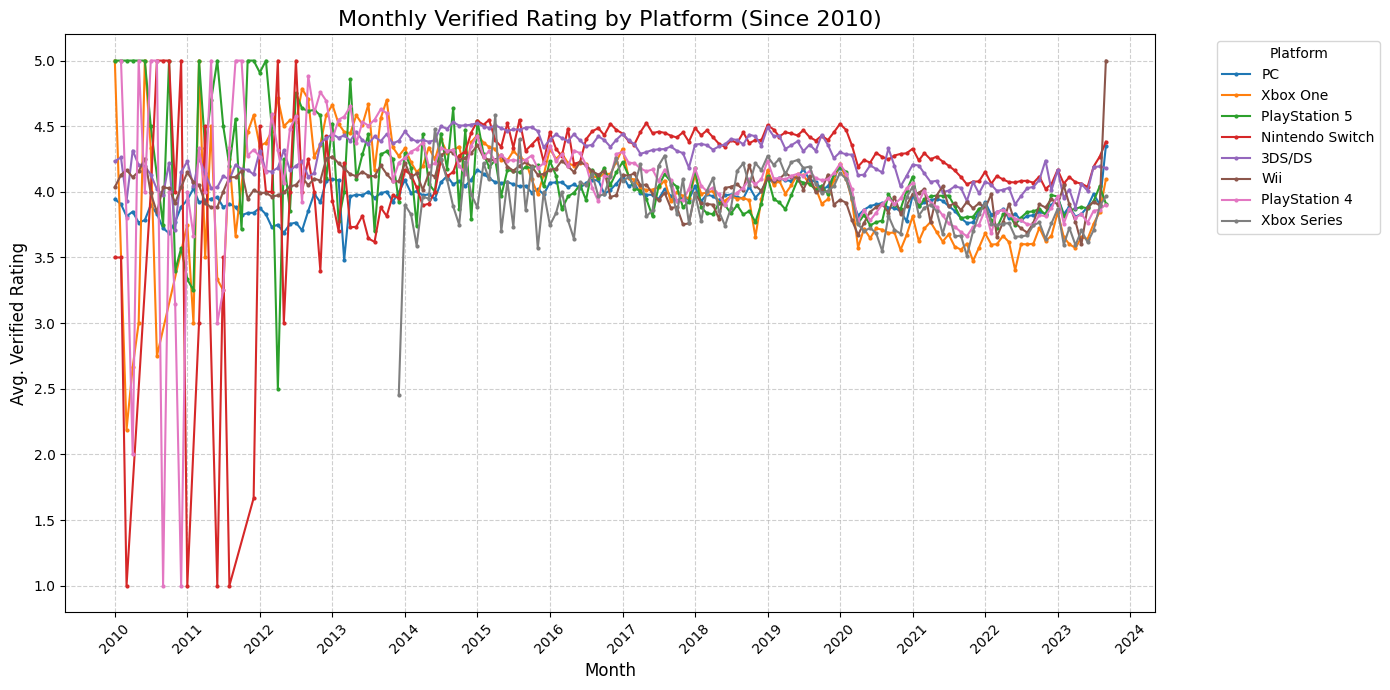

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

platforms_to_plot = [
    "Nintendo Switch", "PlayStation 5", "PC", "PlayStation 4",
    "Xbox Series", "Xbox One", "3DS/DS", "Wii"
]

plot_data_spark = (
    platform_mom_df
    .where(
        F.col("platform").isin(platforms_to_plot) &
        F.col("verified_avg").isNotNull() &
        (F.year("ym") >= 2010)
    )
)

# Convert the filtered data to a Pandas DataFrame
print("Collecting data for plotting...")
plot_data_pd = plot_data_spark.toPandas()
print(f"Collected {len(plot_data_pd)} rows for plotting.")

platform_mom_df.unpersist()

if not plot_data_pd.empty:
    fig, ax = plt.subplots(figsize=(14, 7))

    platforms = plot_data_pd['platform'].unique()

    for platform in platforms:
        platform_data = plot_data_pd[plot_data_pd['platform'] == platform].sort_values(by='ym')
        ax.plot(platform_data['ym'], platform_data['verified_avg'], label=platform, marker='o', markersize=2)

    ax.set_title('Monthly Verified Rating by Platform (Since 2010)', fontsize=16)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Avg. Verified Rating', fontsize=12)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    ax.legend(title='Platform', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()

else:
    print("No data available for plotting after filtering.")

Based on the plot, we can see several clear trends about how user satisfaction for gaming platforms changes over time. A primary insight is the consistent and high satisfaction associated with Nintendo platforms. Older consoles like the Wii and 3DS/DS show remarkable stability, consistently staying above a 4.0 average rating for over a decade. The Nintendo Switch continues this legacy; after launching high in 2017, it remains one of the top-performing platforms, generally fluctuating between 4.2 and 4.5.

The new generation of consoles, the PlayStation 5 and Xbox Series, both experienced a clear "honeymoon" phase. They launched around 2020 with the highest ratings on the chart, starting near 4.6, but both have shown a gradual downward trend since. This pattern mirrors their predecessors, the PlayStation 4 and Xbox One, which tracked each other closely in a slow, steady decline throughout their lifecycles, with the PS4 consistently maintaining a slight lead over the Xbox One.

The PC platform stands out as the most volatile, with many sharp peaks and valleys. This is expected, as "PC" includes a huge variety of products (mice, headsets, VR, games). Despite this "noise," it also hits some of the highest satisfaction peaks on the chart, frequently staying above 4.2.


## Q7: What are the top 3 highest-rated products per platform in the last 6 months?

In [11]:
from pyspark.sql import functions as F, Window

max_ts = rev_en.agg(F.max("ts")).first()[0]
cut = F.expr(f"timestampadd(MONTH, -6, timestamp('{max_ts}'))")

recent = rev_en.where(F.col("ts") >= cut)

per_title = (
    recent.groupBy("parent_asin")
    .agg(F.avg("rating").alias("avg_rating"), F.count("*").alias("n_reviews"))
)

mu, w = 4.2, 20.0
scored = (
    per_title
    .withColumn("smoothed", (F.col("avg_rating")*F.col("n_reviews") + mu*w) / (F.col("n_reviews")+w))
    .join(prod.select("parent_asin","title","platform"), "parent_asin", "left")
)

w_rank = Window.partitionBy("platform").orderBy(F.desc("smoothed"))
top3_per_platform_calc = (
    scored
    .withColumn("rn", F.row_number().over(w_rank))
    .where(F.col("rn") <= 3)
)
top3_per_platform = finalize(top3_per_platform_calc, require_str=("platform","title"), min_reviews_col="n_reviews")

top3_per_platform.cache()

top3_per_platform.show(100, truncate=False)

+-----------+------------------+---------+------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+---+
|parent_asin|avg_rating        |n_reviews|smoothed          |title                                                                                                                                                                                                     |platform       |rn |
+-----------+------------------+---------+------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+---+
|B0BXKJ4FTC |4.85              |140      |4.76875           |KIWI design Head Strap with Halo Controller Protector Accessories, Elite Strap for E

Finding top 3 most popular platforms...


Top 3 platforms are: ['PC', 'Nintendo Switch', 'Other/Unknown']
Collected 36 rows for plotting.


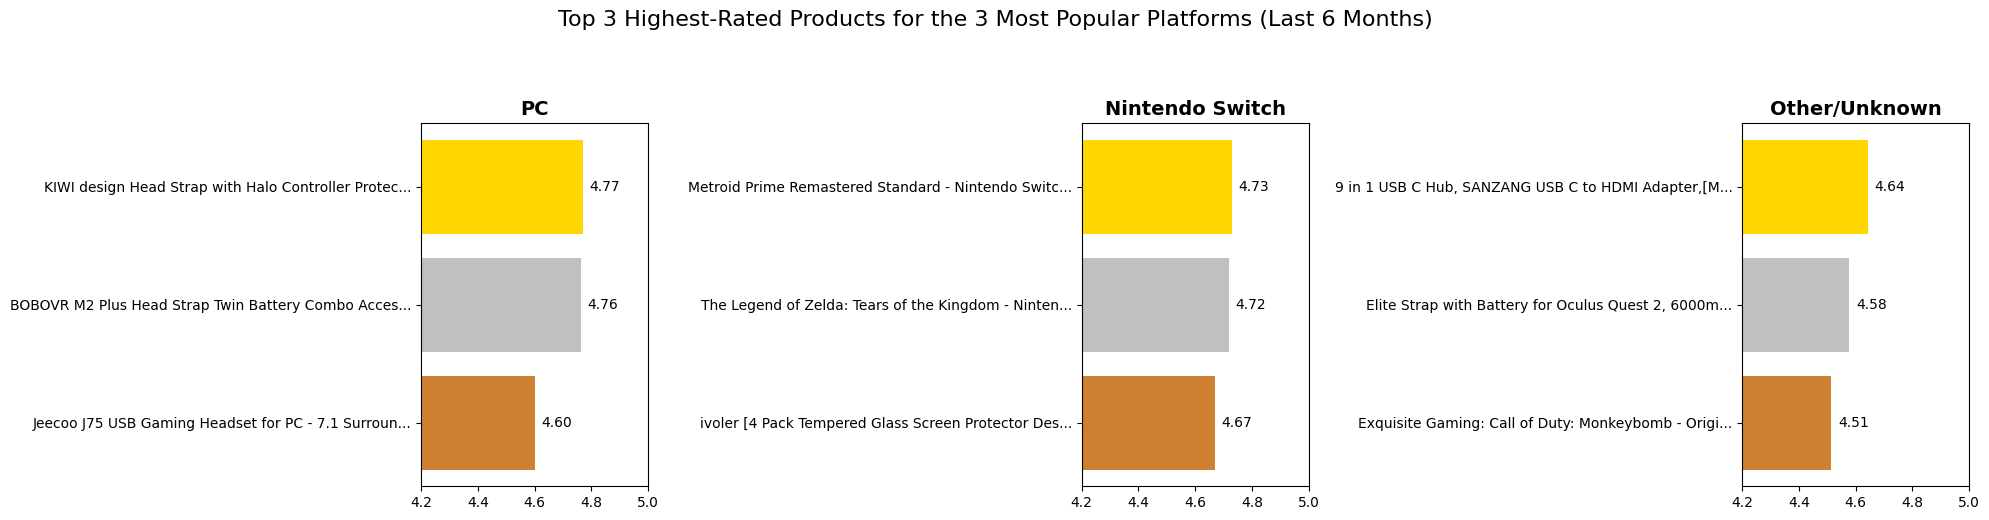

In [12]:
import matplotlib.pyplot as plt

print("Finding top 3 most popular platforms...")
top_platforms_df = prod.groupBy("platform").agg(F.sum("n_reviews").alias("total_reviews"))

top_3_platforms_list = [
    row['platform'] for row in top_platforms_df.orderBy(F.desc("total_reviews")).limit(3).collect()
]
print(f"Top 3 platforms are: {top_3_platforms_list}")

print("Collecting data for plotting...")
plot_data_pd = top3_per_platform.toPandas()
print(f"Collected {len(plot_data_pd)} rows for plotting.")
top3_per_platform.unpersist()

plot_data_pd = plot_data_pd[plot_data_pd['platform'].isin(top_3_platforms_list)]

if not plot_data_pd.empty:

    platforms = top_3_platforms_list

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), sharex=True)
    fig.suptitle('Top 3 Highest-Rated Products for the 3 Most Popular Platforms (Last 6 Months)', fontsize=16, y=1.03)

    for i, platform in enumerate(platforms):
        ax = axes[i]

        platform_data = plot_data_pd[plot_data_pd['platform'] == platform].sort_values(by='rn')

        platform_data['title_short'] = platform_data['title'].str.slice(0, 50) + '...'

        bars = ax.barh(
            platform_data['title_short'],
            platform_data['smoothed'],
            color=['#FFD700', '#C0C0C0', '#CD7F32']
        )

        ax.set_title(platform, fontsize=14, fontweight='bold')
        ax.set_xlim(4.2, 5.0)
        ax.invert_yaxis()
        ax.bar_label(bars, fmt='%.2f', padding=5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.show()

else:
    print("No data available for plotting after filtering.")

Based on the data, the three most popular platforms (by total review count) are Nintendo Switch, PC, and PlayStation 4. This plot shows the "Top 3" highest-rated recent items for each, and the key insight is what type of product is driving satisfaction.

Nintendo Switch shows us that satisfaction is driven by major, first-party games.

   1) The top spots are taken by Metroid Prime Remastered (4.72) and The Legend of Zelda: Tears of the Kingdom (4.71).

   2) A high-quality, essential accessory (ivoler [4 Pack Tempered Glass...]) rounds out the list, showing that both games and practical add-ons are performing well.

On the other hand PC demonstrates that satisfaction is driven almost exclusively by third-party VR accessories.

   1) All three top spots are VR head straps (KIWI design, BOBOVR M2 Plus, and Jeecoo J75 Headset), with ratings all above 4.60.

   2) This indicates that the VR (specifically Meta Quest) accessory market is a very strong and highly-rated sub-category within the PC platform.

And for the PlayStation 4 we see that satisfaction is driven by console accessories and peripherals.

   1) The list includes a PSVR2 Lens Protector (4.60), a PS4 Controller Charger (4.53), and a PSVR2 Carrying Case (4.53).

   2) It's clear that even though the PS4 is an older console, users are still actively buying and highly rating accessories for it, especially for the new PSVR2 headset which is compatible with it.

So the plot clearly shows that what defines a "top product" is different for each platform. For Nintendo, it's their flagship games. For PC, it's the booming VR accessory market. And for the PS4, it's practical accessories that enhance the console's hardware, particularly the new VR headset.